<h1>Datetime recognizer</h1>
Train a model to recognize any datetimes in a given text string. 

Start with simple iso8601s and then progress to locales, timezones, countries & conventions.


Starting from the Keras autoencoder example.

In [1]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'
os.environ['CUDA_HOME'] = '/usr/local/cuda'

In [2]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning to decode localized datetimes from strings
Input: "Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"
or
       "Monday, 24 October 1977 at 09:10:55 Greenwich Mean Time"
Output: "2007-12-31T07:07:07.00000+02:00"
Padding is handled by using a repeated sentinel character (space)


Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.

'''
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Dropout, Flatten, Embedding ,Merge
from keras.layers.convolutional import Convolution1D, Cropping1D, UpSampling1D, Convolution2D
from keras.layers.pooling import MaxPooling1D
from keras.layers.local import LocallyConnected1D
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.layers.wrappers import Bidirectional
from keras.layers.core import Reshape
#from keras.callbacks import ReduceLROnPlateau
import numpy as np
from six.moves import range
import pytz
from datetime import datetime, timezone
import itertools
import random
from babel import Locale, localedata, UnknownLocaleError
from babel.dates import format_datetime
from tqdm import tqdm
import sys
import string
import math

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import math

In [4]:
%matplotlib inline

In [5]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, country_codes, maxlen):
        self.chars = set(string.ascii_letters + 
                         string.punctuation + 
                         string.digits
                        )

        ts_from = int(datetime(1980, 1, 1, tzinfo=timezone.utc).timestamp())
        ts_to   = int(datetime(1981, 1, 1, tzinfo=timezone.utc).timestamp())
        tstamps = [t for t in range(ts_from, ts_to, 60*1000)]
        retries = 0
        
        #Hoover up all the non-ascii characters that might be needed
        for country_code in tqdm(country_codes):
            try:                            
                if pytz.country_timezones.get(country_code):
                    for ctzone in pytz.country_timezones(country_code):
                        tzone = pytz.timezone(ctzone)
                        country_locale = Locale.parse('und_' + country_code)
                        for fmt  in ['short','medium','long','full']:
                            ydts = [datetime.utcfromtimestamp(t).replace(tzinfo=tzone) for t in tstamps]
                            if random.choice([True, False]):
                                X = [format_datetime(dt, format=fmt, locale=country_locale) for dt in ydts]
                            else:
                                sep = random.choice([' ','T'])
                                X = [dt.isoformat(sep) for dt in ydts]

                            # So that's a years worth of datetimes for all the countrys & locales & timezones 
                            for ln in X:
                                # Going with case sensitive because some dt formats have an "i"
                                self.chars = self.chars.union( set(iter(ln)))
                                
            except UnknownLocaleError:
                print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
                retries += 1
                if retries >=21:
                    raise # Somethings gone wrong!

        self.chars = sorted(self.chars)

        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, sentence, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        chunk_size = len(self.chars)
        X = np.zeros((maxlen, chunk_size))
        for idx, c in enumerate(sentence[:maxlen]):
            X[idx, self.char_indices[c]] = 1
        return X

    def decode(self, X, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        ret = []
        chunk_size = len(self.chars)
        for idx in range(maxlen):
            retidx = X[idx,:].argmax(axis=-1)
            ret.append(self.indices_char[retidx])
        return ''.join(ret)


In [6]:
TESTSTRING = 'Monday 21st 1998-01-11 +GMT'
ctable = CharacterTable(['GB',], len("Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"))
xxx = ctable.encode(TESTSTRING)
yyy = ctable.decode(xxx)
print('Encoded.shape: %s' % str(xxx.shape))
print('Decoded: %s' % yyy)
assert(yyy.strip() == TESTSTRING)


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

Encoded.shape: (58, 95)
Decoded: Monday 21st 1998-01-11 +GMT                               


In [7]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [8]:
def DateTimeDataGenerator(sample_size):   
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = [random.randrange(0xFFFFFFFF) for _ in range(sample_size)]

        yield tstamps


In [9]:
def DateTimeFormattedGenerator(country_codes, sample_size, maxlen_x, maxlen_y):
    dtdg = DateTimeDataGenerator(sample_size)
    all_locales = localedata.locale_identifiers()
    limit          = 8
    locale_choices = []
    retries        = 0
    
    # Gather country and timezone options
    for country_code in country_codes:
        try:                            
            if pytz.country_timezones.get(country_code):
                for ctzone in pytz.country_timezones(country_code):
                    tzone = pytz.timezone(ctzone)
                    country_locale = Locale.parse('und_' + country_code)
                    for fmt  in ['short','medium','long','full']:
                        locale_choices.append({'country_code': country_code,
                                               'timezone'    : tzone,
                                               'format'      : fmt,
                                               'locale'      : country_locale
                                              })
        except UnknownLocaleError:
            print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
            retries += 1
            if retries >= 21:
                raise
    
    locale_choices = (locale_choices * math.ceil(sample_size/len(locale_choices)))[:sample_size]
    random.shuffle(locale_choices)
    
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = next(dtdg)
        
        ydts  = [ datetime.utcfromtimestamp(t).replace(tzinfo=locale_choices[idx]['timezone']).isoformat('T') 
                  for idx, t in enumerate(tstamps)]        
        X = [format_datetime(datetime.utcfromtimestamp(t).replace(
                     tzinfo=locale_choices[idx]['timezone']), 
                     format=locale_choices[idx]['format'], 
                     locale=locale_choices[idx]['locale']
                     ) 
             for idx, t in enumerate(tstamps)]

        # pad or chop to length
        X    = [(pp + (' '*maxlen_x))[:maxlen_x] for pp in X]
        ydts = [(pp + (' '*maxlen_y))[:maxlen_y] for pp in ydts]
            
        yield (X, ydts)

In [23]:
MAXLEN_X = 72 # longer than anything expected like 'Monday 31 December 2000 07:07:07.0000000 +02:00 CET/Europe'
MAXLEN_Y = MAXLEN_X # It's 0 padded anyway #len(datetime.now().isoformat(' '))

def DateTimeVectorGenerator(dt_generator, ctable, invert):    
    """
    Returns: x_batch [batch_size, n_timesteps, vocab_size] 
             y_batch [batch_size, n_categories]
    """
    X_next, y_next = next(dt_generator)
    while True:
        # X_next are all the same MAXLEN_X length. Same for y_next
        X = np.zeros((len(X_next), MAXLEN_X, CHARSET_LEN), dtype=np.bool)
        y = np.zeros((len(y_next), MAXLEN_Y, CHARSET_LEN), dtype=np.bool)
        
        for idx, sentence in enumerate(X_next):
            X[idx] = np.flipud(ctable.encode(sentence, MAXLEN_X)) if invert else ctable.encode(sentence, MAXLEN_X)
            
        for idx, sentence in enumerate(y_next):
            y[idx] = ctable.encode(sentence, MAXLEN_Y)
    
        yield [X, X, X, X], y

In [24]:
def visualize_history(learning_hist, data_filename=None):    
    plt.figure(figsize=(12, 6))
    discard = int(math.ceil(len(learning_hist)/100))*20
    # skip the first few, they destroy plot scale
    plt.plot([i for i in learning_hist[-1].history['loss'][discard:]], label='loss')
    plt.plot([i for i in learning_hist[-1].history['val_loss'][discard:]], label='val_loss')

    plt.ylabel('error')
    plt.xlabel('iteration')
    plt.legend()
    #plt.ylim([0, 0.005])
    plt.title('training error')
    if (data_filename is not None):
        plt.savefig(data_filename)
        plt.close()
    else:
        plt.show()

In [25]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.003 #0.0016875 #0.000533935546875 #0.003
    drop = 0.80 #0.75
    epochs_drop = 33.0        
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))    
    
    if not epoch % epochs_drop:
        print('Learning rate adjusted: {}'.format(lrate), file=sys.stderr)
    
    return lrate

In [26]:
# Parameters for the model and dataset
TRAINING_SIZE   = 3456 #tuned to avoid ResourceExhaustedError: OOM when allocating tensor with shape
VALIDATION_SIZE = 345
INVERT = True
# Try replacing GRU, LSTM or SimpleRNN
RNN = recurrent.GRU
BATCH_SIZE = 128
LAYERS = 4

# pytz.country_names.keys()
COUNTRY_CODES = ['GB', 'US', 'IE', 'AU', ] #'DE','FR','ES','IT','CA', 'NO','SE','DK','FI','EE','CZ','PL'] 
EPOCHS=101
HIDDEN_SIZE = math.ceil(MAXLEN_X * 1.5) # GRU #9 - SimpleRNN to 80%acc




In [27]:
ctable = CharacterTable(COUNTRY_CODES, MAXLEN_X)
CHARSET_LEN = len(ctable.chars)

100%|██████████| 4/4 [00:05<00:00,  1.08s/it]


In [28]:
#gen_dt = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_train      = DateTimeVectorGenerator(gen_dt, ctable, INVERT)
gen_vec_validation = DateTimeVectorGenerator(gen_dt, ctable, INVERT)

X_train, y_train = next(gen_vec_train)
print('X_train[0].shape: %s'%str(X_train[0].shape))
print('y_train.shape: %s'%str(y_train.shape))

X_train[0].shape: (3456, 72, 95)
y_train.shape: (3456, 72, 95)


In [29]:
#gen_dt_test = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt_test = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_test = DateTimeVectorGenerator(gen_dt_test, ctable, INVERT)

X_test, y_test = next(gen_vec_test)
print('X_test[0].shape:%s \ny_test.shape: %s' % (str(X_test[0].shape), str(y_test.shape)))

X_test[0].shape:(3456, 72, 95) 
y_test.shape: (3456, 72, 95)


In [30]:
stopper = EarlyStopping(patience=25, 
                        verbose=1, 
                        mode='auto')

In [31]:
checkpointer = ModelCheckpoint('../models/checkpoint.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

In [32]:
learning_hist = []

In [33]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate, ]

In [34]:
print('Build model...')

filter_lengths = [2,3,4,5] # "dd" or "mm-" or "/mm" or "GMT" or "yyyy"  
conv_filters = []

for fl in filter_lengths:
    conv_filters.append(Sequential())
    conv_filters[-1].add(Convolution1D(nb_filter=CHARSET_LEN,
                        filter_length=fl,
                        activation='relu',
                        input_shape=(MAXLEN_X, CHARSET_LEN),
                        subsample_length=1,
                       ))
    conv_filters[-1].add(MaxPooling1D(pool_length=68)) # was 68 


model = Sequential()
model.add(Merge(conv_filters, mode='concat'))
model.add(Dropout(0.33333))
#model.add(Reshape((3,CHARSET_LEN)))
#model.add(MaxPooling1D(pool_length=MAXLEN_Y))
#model.add(recurrent.GRU(HIDDEN_SIZE, return_sequences=False))
model.add(Flatten())
model.add(RepeatVector(MAXLEN_X))
model.add(recurrent.GRU(HIDDEN_SIZE, 
                          activation='relu',
                          return_sequences=True,
                       ))
model.add(Dropout(0.333333))
# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(CHARSET_LEN, 
                                activation='softmax')
                         ))
opt = Nadam(lr=0) # Using LR scheduler

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Build model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_5 (Convolution1D)  (None, 71, 95)        18145                                        
____________________________________________________________________________________________________
maxpooling1d_5 (MaxPooling1D)    (None, 1, 95)         0                                            
____________________________________________________________________________________________________
convolution1d_6 (Convolution1D)  (None, 70, 95)        27170                                        
____________________________________________________________________________________________________
maxpooling1d_6 (MaxPooling1D)    (None, 1, 95)         0                                            
____________________________________________________________________________

Learning rate adjusted: 0.003


Epoch 1/101
114048/114048 [==============================] - 114s - loss: 1.6399 - acc: 0.6390 - val_loss: 1.2678 - val_acc: 0.6887
Epoch 2/101
114048/114048 [==============================] - 75s - loss: 1.1122 - acc: 0.6943 - val_loss: 0.8827 - val_acc: 0.7097
Epoch 3/101
114048/114048 [==============================] - 75s - loss: 0.9455 - acc: 0.7137 - val_loss: 0.8307 - val_acc: 0.7442
Epoch 4/101
114048/114048 [==============================] - 75s - loss: 1.1069 - acc: 0.6789 - val_loss: 0.9805 - val_acc: 0.6818
Epoch 5/101
114048/114048 [==============================] - 74s - loss: 0.9361 - acc: 0.7100 - val_loss: 0.8931 - val_acc: 0.7261
Epoch 6/101
114048/114048 [==============================] - 74s - loss: 0.8483 - acc: 0.7295 - val_loss: 0.7685 - val_acc: 0.7506
Epoch 7/101
114048/114048 [==============================] - 74s - loss: 0.8008 - acc: 0.7413 - val_loss: 0.7925 - val_acc: 0.7592
Epoch 8/101
114048/114048 [==============================] - 74s - loss: 0.7631 - 

Learning rate adjusted: 0.0024000000000000002


114048/114048 [==============================] - 74s - loss: 0.3678 - acc: 0.8569 - val_loss: 0.3254 - val_acc: 0.8763
Epoch 35/101
114048/114048 [==============================] - 75s - loss: 0.3550 - acc: 0.8612 - val_loss: 0.3166 - val_acc: 0.8795
Epoch 36/101
114048/114048 [==============================] - 75s - loss: 0.3463 - acc: 0.8645 - val_loss: 0.3101 - val_acc: 0.8819
Epoch 37/101
114048/114048 [==============================] - 74s - loss: 0.3392 - acc: 0.8677 - val_loss: 0.3043 - val_acc: 0.8835
Epoch 38/101
114048/114048 [==============================] - 75s - loss: 0.3323 - acc: 0.8710 - val_loss: 0.2962 - val_acc: 0.8868
Epoch 39/101
114048/114048 [==============================] - 74s - loss: 0.3252 - acc: 0.8740 - val_loss: 0.2924 - val_acc: 0.8881
Epoch 40/101
114048/114048 [==============================] - 74s - loss: 0.3195 - acc: 0.8768 - val_loss: 0.2848 - val_acc: 0.8933
Epoch 41/101
114048/114048 [==============================] - 74s - loss: 0.3143 - acc: 0

Learning rate adjusted: 0.0019200000000000005


114048/114048 [==============================] - 75s - loss: 0.2409 - acc: 0.9081 - val_loss: 0.2081 - val_acc: 0.9219
Epoch 68/101
114048/114048 [==============================] - 75s - loss: 0.2397 - acc: 0.9086 - val_loss: 0.2055 - val_acc: 0.9232
Epoch 69/101
114048/114048 [==============================] - 74s - loss: 0.2383 - acc: 0.9090 - val_loss: 0.2056 - val_acc: 0.9232
Epoch 70/101
114048/114048 [==============================] - 74s - loss: 0.2368 - acc: 0.9098 - val_loss: 0.2024 - val_acc: 0.9253
Epoch 71/101
114048/114048 [==============================] - 74s - loss: 0.2353 - acc: 0.9103 - val_loss: 0.2026 - val_acc: 0.9254
Epoch 72/101
114048/114048 [==============================] - 75s - loss: 0.2338 - acc: 0.9109 - val_loss: 0.2010 - val_acc: 0.9244
Epoch 73/101
114048/114048 [==============================] - 75s - loss: 0.2322 - acc: 0.9114 - val_loss: 0.2018 - val_acc: 0.9237
Epoch 74/101
114048/114048 [==============================] - 74s - loss: 0.2310 - acc: 0

Learning rate adjusted: 0.0015360000000000005


114048/114048 [==============================] - 75s - loss: 0.1941 - acc: 0.9259 - val_loss: 0.1594 - val_acc: 0.9421
Epoch 101/101
114048/114048 [==============================] - 74s - loss: 0.1933 - acc: 0.9263 - val_loss: 0.1594 - val_acc: 0.9411
Q December 24, 1992 at 1:41:27 PM AKST                                    
T 1992-12-24T13:41:27-11:02                                               
☒ 1992-12-24T12:42:28-00:00                                               
Q Dec 21, 2051, 8:04:29 PM                                                
T 2051-12-21T20:04:29-05:46                                               
☒ 2051-12-21T22:05:20-05:46                                               
Q Wednesday, 4 September 2013 at 6:33:39 am Australian Eastern Standard Ti
T 2013-09-04T06:33:39+09:40                                               
☒ 2013-09-04T05:33:33+09:00                                               
Q Friday, 16 April 2077 at 5:25:09 am Australian Eastern Standard Time   

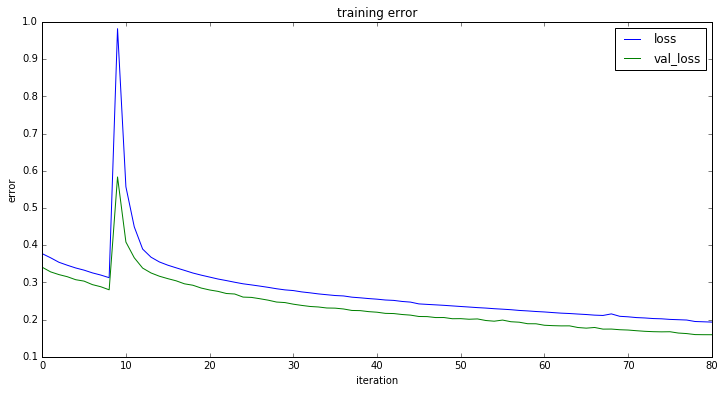

In [35]:
# Train the model each generation and show predictions against the validation dataset

gen_dt_train = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt_val   = DateTimeFormattedGenerator(COUNTRY_CODES, VALIDATION_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_train      = DateTimeVectorGenerator(gen_dt_train, ctable, INVERT)
gen_vec_validation = DateTimeVectorGenerator(gen_dt_val,   ctable, INVERT)

learning_hist.append(
        model.fit_generator( gen_vec_train, 
                            samples_per_epoch = 33 * TRAINING_SIZE,
                            nb_epoch=EPOCHS, 
                            verbose=1, 
                            callbacks=callbacks_list, 
                            validation_data=gen_vec_validation, 
                            nb_val_samples=VALIDATION_SIZE, 
                            #class_weight={}, 
                            #max_q_size=10, 
                            #nb_worker=1, 
                            #pickle_safe=False
                           )
        )

model.save('../models/datatime_conv_mkI.h5')

for idx in range(5):
    X_test, y_test = next(gen_vec_test)            
    preds = model.predict(X_test, verbose=0)
    i = random.randrange(len(preds))    
    q = ctable.decode(X_test[0][i], MAXLEN_X)    
    correct = ctable.decode(y_test[i], MAXLEN_Y)
    guess = ctable.decode(preds[i], MAXLEN_Y)
    print('Q', q[::-1] if INVERT else q )
    print('T', correct)
    print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

visualize_history(learning_hist)            

In [ ]:
MAXLEN_X - MAXLEN_Y

<h1>Results</h1>



~~~
print('Build model...')

filter_lengths = [2,3,4,5] # "dd" or "mm-" or "/mm" or "GMT" or "yyyy"  
conv_filters = []

for fl in filter_lengths:
    conv_filters.append(Sequential())
    conv_filters[-1].add(Convolution1D(nb_filter=CHARSET_LEN,
                        filter_length=fl,
                        activation='relu',
                        input_shape=(MAXLEN_X, CHARSET_LEN),
                        subsample_length=1,
                       ))
    conv_filters[-1].add(MaxPooling1D(pool_length=68)) # was 68 


model = Sequential()
model.add(Merge(conv_filters, mode='concat'))
model.add(Dropout(0.33333))
model.add(Flatten())
model.add(RepeatVector(MAXLEN_X))
model.add(recurrent.GRU(HIDDEN_SIZE, 
                          activation='relu',
                          return_sequences=True,
                       ))
model.add(Dropout(0.333333))
model.add(TimeDistributed(Dense(CHARSET_LEN, 
                                activation='softmax')
                         ))
opt = Nadam(lr=0) # Using LR scheduler
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()
~~~

~~~
Epoch 90/101
114048/114048 [==============================] - 74s - loss: 0.2089 - acc: 0.9206 - val_loss: 0.1728 - val_acc: 0.9370
Epoch 91/101
114048/114048 [==============================] - 74s - loss: 0.2075 - acc: 0.9211 - val_loss: 0.1719 - val_acc: 0.9376
Epoch 92/101
114048/114048 [==============================] - 74s - loss: 0.2054 - acc: 0.9218 - val_loss: 0.1701 - val_acc: 0.9384
Epoch 93/101
114048/114048 [==============================] - 74s - loss: 0.2044 - acc: 0.9222 - val_loss: 0.1685 - val_acc: 0.9384
Epoch 94/101
114048/114048 [==============================] - 75s - loss: 0.2028 - acc: 0.9227 - val_loss: 0.1675 - val_acc: 0.9384
Epoch 95/101
114048/114048 [==============================] - 75s - loss: 0.2021 - acc: 0.9231 - val_loss: 0.1671 - val_acc: 0.9381
Epoch 96/101
114048/114048 [==============================] - 74s - loss: 0.2005 - acc: 0.9236 - val_loss: 0.1674 - val_acc: 0.9379
Epoch 97/101
114048/114048 [==============================] - 75s - loss: 0.1997 - acc: 0.9240 - val_loss: 0.1639 - val_acc: 0.9406
Epoch 98/101
114048/114048 [==============================] - 74s - loss: 0.1988 - acc: 0.9243 - val_loss: 0.1624 - val_acc: 0.9405
Epoch 99/101
114048/114048 [==============================] - 75s - loss: 0.1949 - acc: 0.9257 - val_loss: 0.1597 - val_acc: 0.9428
Epoch 100/101
Learning rate adjusted: 0.0015360000000000005
114048/114048 [==============================] - 75s - loss: 0.1941 - acc: 0.9259 - val_loss: 0.1594 - val_acc: 0.9421
Epoch 101/101
114048/114048 [==============================] - 74s - loss: 0.1933 - acc: 0.9263 - val_loss: 0.1594 - val_acc: 0.9411
~~~

In [36]:
X_test, y_test = next(gen_vec_validation)            
preds = model.predict(X_test, verbose=0)
for idx in range(10):
    i = random.randrange(len(preds))    
    q = ctable.decode(X_test[0][i], MAXLEN_X)    
    correct = ctable.decode(y_test[i], MAXLEN_Y)
    guess = ctable.decode(preds[i], MAXLEN_Y)
    print('Q', q[::-1] if INVERT else q )
    print('T', correct)
    print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

Q August 26, 2071 at 8:09:54 AM MST                                       
T 2071-08-26T08:09:54-07:45                                               
☒ 2071-08-26T08:09:59-07:50                                               
Q Nov 14, 2068, 7:16:59 AM                                                
T 2068-11-14T07:16:59-05:45                                               
☒ 2068-11-14T07:15:45-05:46                                               
Q April 22, 2097 at 1:38:47 PM MST                                        
T 2097-04-22T13:38:47-07:28                                               
☒ 2097-04-22T13:38:48-07:50                                               
Q Friday, August 13, 2038 at 7:39:12 PM Eastern Standard Time             
T 2038-08-13T19:39:12-05:39                                               
☒ 2038-08-13T19:39:19-05:49                                               
Q Tuesday, January 8, 1974 at 2:23:41 AM Eastern Standard Time            
T 1974-01-08T02:23:41-05:

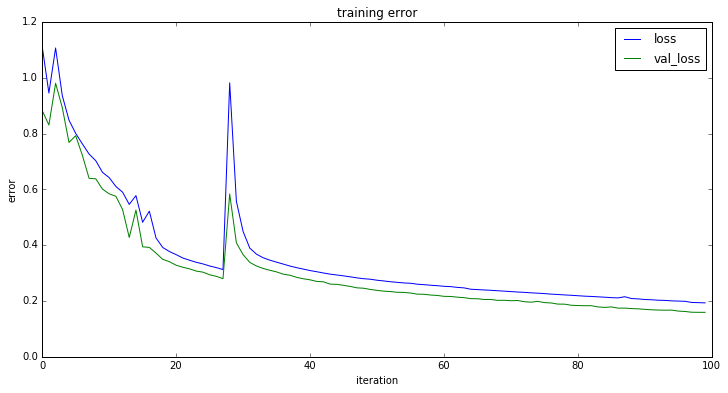

In [37]:
plt.figure(figsize=(12, 6))
discard = int(math.ceil(len(learning_hist)/100))*1
# skip the first few, they destroy plot scale
plt.plot([i for i in learning_hist[-1].history['loss'][discard:]], label='loss')
plt.plot([i for i in learning_hist[-1].history['val_loss'][discard:]], label='val_loss')

plt.ylabel('error')
plt.xlabel('iteration')
plt.legend()
#plt.ylim([0, 0.005])
plt.title('training error')
plt.show()

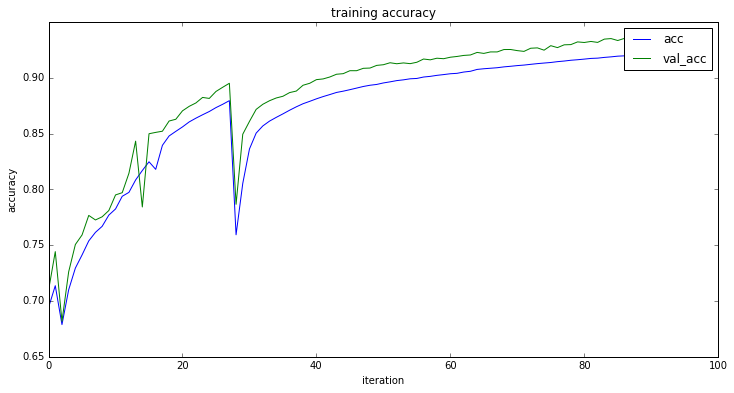

In [38]:
plt.figure(figsize=(12, 6))
discard = int(math.ceil(len(learning_hist)/100))*1
# skip the first few, they destroy plot scale
plt.plot([i for i in learning_hist[-1].history['acc'][discard:]], label='acc')
plt.plot([i for i in learning_hist[-1].history['val_acc'][discard:]], label='val_acc')

plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend()
#plt.ylim([0, 0.005])
plt.title('training accuracy')
plt.show()

In [ ]:
#len(learning_hist[0].history['loss'])

In [ ]:
#model.save('../models/datatime_autoencoder_model.h5')

In [ ]:
next(gen_dt)

In [ ]:
#model.load_weights('../models/datatime_conv_mkI.h5')

In [ ]:
!! ls ../models/


In [ ]:
# A smidge more training ...
learning_hist.append(
        model.fit_generator( gen_vec_train, 
                            samples_per_epoch = 33 * TRAINING_SIZE,
                            nb_epoch=20, 
                            verbose=1, 
                            #callbacks=callbacks_list, 
                            validation_data=gen_vec_validation, 
                            nb_val_samples=VALIDATION_SIZE, 
                            #class_weight={}, 
                            #max_q_size=10, 
                            #nb_worker=1, 
                            #pickle_safe=False
                           )
        )

Epoch 1/20
114048/114048 [==============================] - 77s - loss: 0.1924 - acc: 0.9266 - val_loss: 0.1577 - val_acc: 0.9426
Epoch 2/20
114048/114048 [==============================] - 75s - loss: 0.1912 - acc: 0.9270 - val_loss: 0.1579 - val_acc: 0.9427
Epoch 3/20
 13824/114048 [==>...........................] - ETA: 66s - loss: 0.1905 - acc: 0.9272